# Adam local optimiser

_Adam_ (from "adaptive moment estimation") is a local gradient-descent-with-momentum method, similar to AdaGrad and RMSProp. It uses a fixed step size, but maintains two _momentum_ parameters which are continuously updated.

Very clear psuedocode is given in [this paper](https://doi.org/10.48550/arXiv.1412.6980) (Algorithm 1).

## Example 1: finding the bottom of a parabolic valley

As a first test we optimise on a parabola, centered at the origin:

In [13]:
import pints
import pints.toy

# Create a parabolic error function
error = pints.toy.ParabolicError()

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the error function on a grid of points
X = np.arange(-2, 2.1, 0.1)
Y = np.arange(-1, 1.1, 0.1)
Z = np.zeros((len(Y), len(X)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[j, i] = error((x, y))
X, Y = np.meshgrid(X, Y)

# Define a function to create a contour plot
def create_contour_plot():

    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    ax.set_aspect('equal')
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)

    # Plot the contours
    plt.contour(X, Y, Z, levels=20)
    
    # Show where the optimum is
    plt.plot([0], [0], 'x', color='red', label='optimum', markersize=20)

We choose a starting point and make a plot:

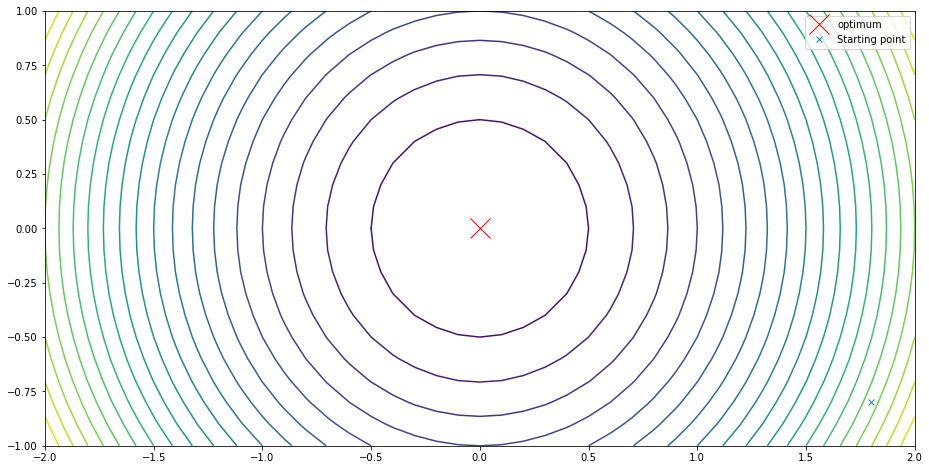

In [15]:
# Create a contour plot
create_contour_plot()

# Choose a starting point for the optimisation
x0 = [1.8, -0.8]

# Show the starting point
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Show the whole figure
plt.legend()
plt.show()

Now we create an optimiser and use the ask-and-tell interface to let it walk a few steps.
The step size will be set using the `sigma0` parameter:

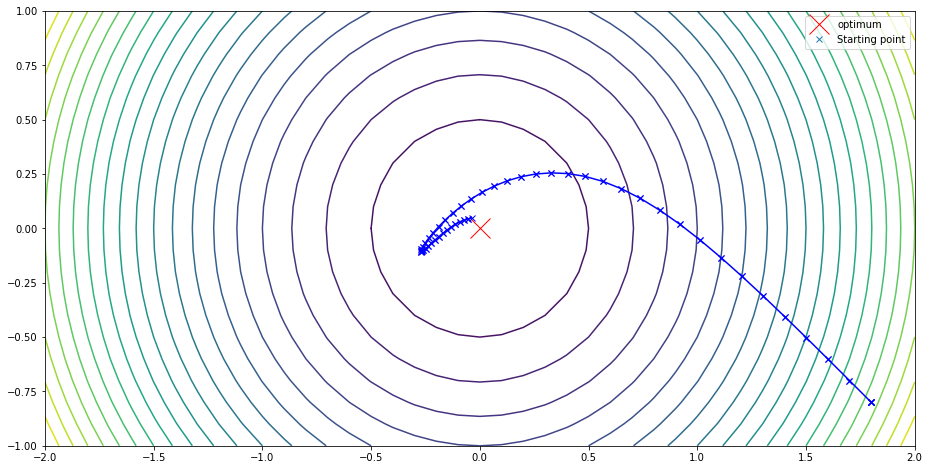

In [16]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create an optimiser
opt = pints.Adam(x0, 0.1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

We can immediately see the "momentum" in effect: the optimiser quickly overshoots and travels up the gradient, before starting down it again.

If we like, we can be cheeky and make the step size much too large:

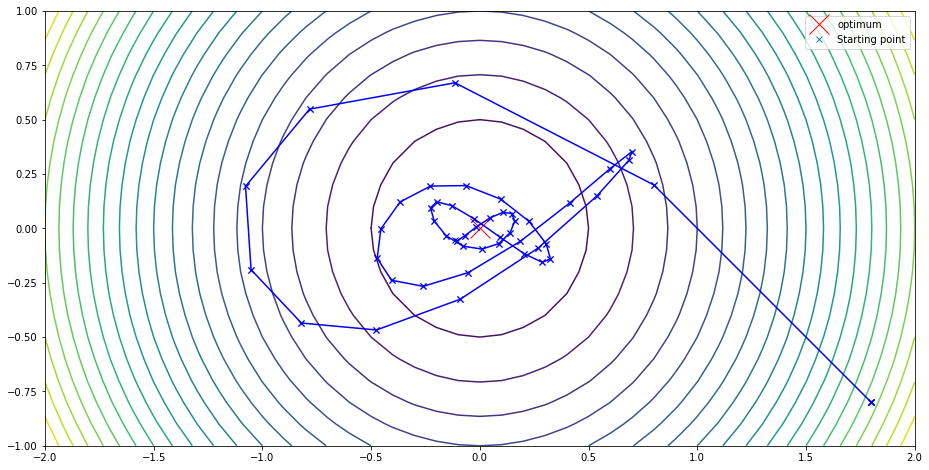

In [18]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create an optimiser
opt = pints.Adam(x0, 1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

Wheeeeeee!

Despite our bad initial settings, the method quite quickly recovers and starts moving towards the optimum. Note how the momentum decreases over time.

## Example 2: Maximising a difficult LogPDF

We can also try this method on the ["banana" twisted gaussian LogPDF](https://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html).

Because this is a LogPDF and our optimiser minimises, we need to wrap it in a [ProbabilityBasedError](https://pints.readthedocs.io/en/latest/error_measures.html#pints.ProbabilityBasedError). Note that this is only necessary for manual ask-and-tell: if we use the OptimiserController it does this bit for us!

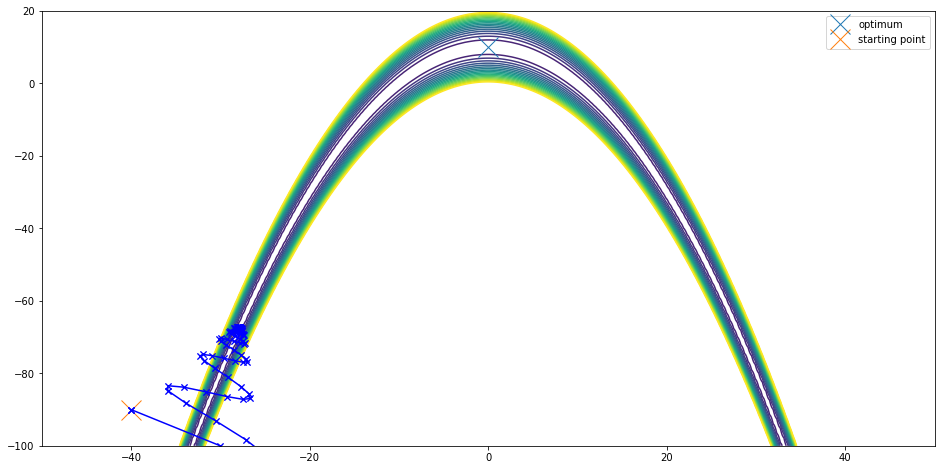

In [20]:
# Define a LogPDF (a 2-dimensional twisted gaussian)
logpdf = pints.toy.TwistedGaussianLogPDF(dimension=2)

# Wrap an error around the LogPDF
error = pints.ProbabilityBasedError(logpdf)

# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)

# Evaluate the error function on a grid of points
levels = np.linspace(1, 50, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=levels)

# Show the optimum
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Pick a starting point
x0 = [-40, -90]
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Create an optimiser
opt = pints.Adam(x0, 10)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(400):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

The method performs a bit better than other methods like fixed step-size gradient descent, but still gets stuck pretty quickly.

We can try to remedy this by trying some different step sizes:

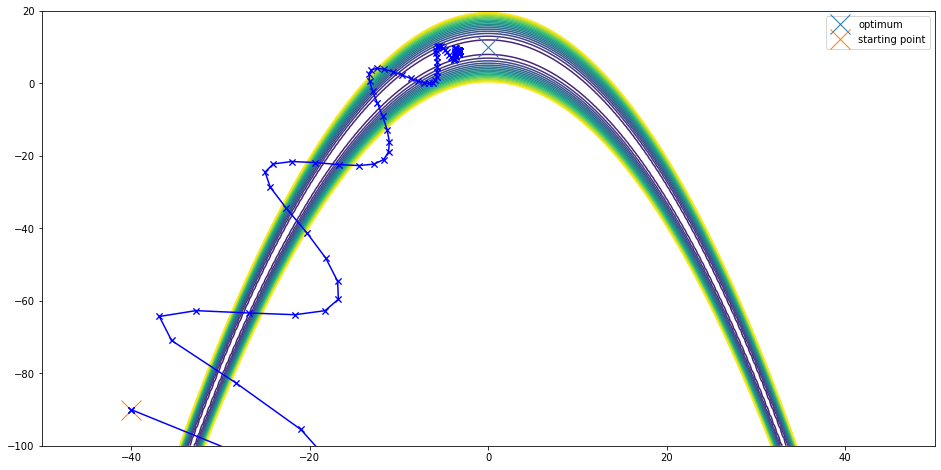

In [22]:
def try_again(sigma0):
    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    plt.xlim(-50, 50)
    plt.ylim(-100, 20)
    plt.contour(X, Y, Z, levels=levels)
    plt.plot(0, 10, 'x', markersize=20, label='optimum')
    plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

    opt = pints.Adam(x0, sigma0)
    e = pints.SequentialEvaluator(error.evaluateS1)

    x1 = x0
    for i in range(400):
        xs = opt.ask()
        fs = e.evaluate(xs)
        opt.tell(fs)

        x2 = xs[0]
        plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
        x1 = x2

    plt.legend()
    plt.show()
    
try_again(20)

That seems to have worked pretty well! Are bigger step sizes the answer?

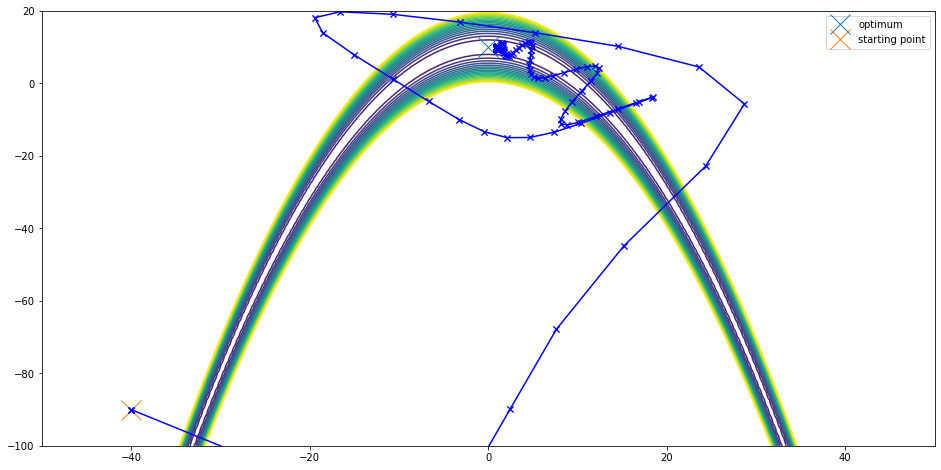

In [23]:
try_again(30)

This looks _very_ messy, but does get near the optimum! Maybe if we pick a step size somewhere in between?

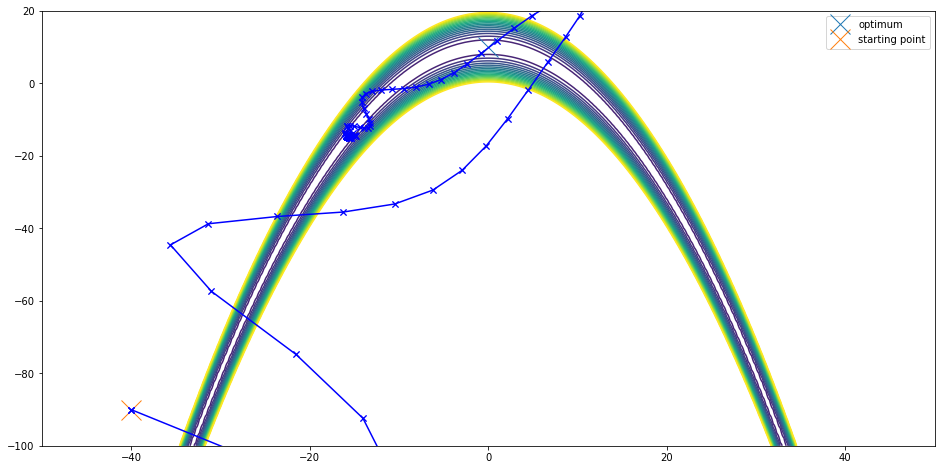

In [24]:
try_again(25)

Nope! It appears we were just a bit lucky, and this problem is too hard for this method.

## Example 3: A noisy time-series problem

Finally, we apply this method to a noisy time series problem:

In [26]:
# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    sigma0=0.01,
    method=pints.Adam
)
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Adam
Running in sequential mode.
Iter. Eval. Best      Current   Time m:s
0     1      1.94e+07  1.94e+07   0:00.0
1     2      1.94e+07  1.94e+07   0:00.0
2     3      4952241   4952241    0:00.0
3     4      4952241   1.27e+07   0:00.0
20    21     1298790   4134843    0:00.0
40    41     1279891   2070314    0:00.0
60    61     1272000   1339598    0:00.0
80    81     1258777   1270673    0:00.0
100   101    1247454   1247454    0:00.0
120   121    1238352   1238352    0:00.0
140   141    1229196   1229196    0:00.0
160   161    1220145   1220145    0:00.0
180   181    1211155   1211155    0:00.0
200   201    1202215   1202215    0:00.0
220   221    1193328   1193328    0:00.0
240   241    1184493   1184493    0:00.0
260   261    1175711   1175711    0:00.0
280   281    1166981   1166981    0:00.0
300   301    1158304   1158304    0:00.0
320   321    1149679   1149679    0:00.0
340   341    1141105   1141105    0:00.0
360   361    1132584   1132584    

4920  4921   163624.5  204231     0:00.6
4940  4941   163624.5  166324.9   0:00.6
4960  4961   163624.5  239170.2   0:00.6
4980  4981   159158.1  168640.9   0:00.6
5000  5001   159158.1  190595.5   0:00.6
5020  5021   159158.1  161557.3   0:00.6
5040  5041   159158.1  222357.2   0:00.6
5060  5061   154871.5  186082.6   0:00.6
5080  5081   154871.5  162146.9   0:00.6
5100  5101   154871.5  214391.2   0:00.6
5120  5121   150918.4  151207.8   0:00.6
5140  5141   150918.4  253446.2   0:00.6
5160  5161   149057.3  162742.1   0:00.6
5180  5181   149057.3  167052.9   0:00.6
5200  5201   149057.3  168358.5   0:00.6
5220  5221   149057.3  153286.1   0:00.6
5240  5241   145333.1  169624.8   0:00.6
5260  5261   144786.7  144786.7   0:00.6
5280  5281   143628.1  187098.1   0:00.6
5300  5301   143628.1  145151     0:00.7
5320  5321   143628.1  193247.9   0:00.7
5340  5341   140131.2  150846.4   0:00.7
5360  5361   140131.2  152507.4   0:00.7
5380  5381   140131.2  169607     0:00.7
5400  5401   138

This works, but it takes more than 9000 evaluations! Note also how we had to choose our step size quite carefully.